In [3]:
import os
from dotenv import load_dotenv

from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_groq import ChatGroq
from langchain_qdrant import QdrantVectorStore
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import trim_messages, BaseMessage, HumanMessage, ToolMessage
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory

from langgraph.graph import END, START, StateGraph

In [4]:

load_dotenv()


True

In [40]:

PROMPT_TEMPLATE = """
Answer the question  or check the correctness of the response based on the following context:

{context}

----
Use latex formatting for equations. Enclose equations in $ sign.
Use markdown formatting for everything else.
Here's the user input: {query}
----
If this is a question answer the question, if this is an attempt to answer a previous question, check if the answer is correct.
"""

SUMMARIZATION_PROMPT="""
You are a summarizer of text tasked with summarizing the chat conversation between a student and a teaching assistant.
Present in the summary are also thoughts of the teaching assistant on how to answer the student's queries which are
not present in the actual conversation because the assistant wants to help the student arrive at the answer themselves instead
of simply giving the answer.
Here is the summary of their conversation so far, the assistant's extra thoughts and the last couple of messages exchanged:

{context}


Summarize this conversation so that another teaching assistant could read it and understand the problem the student is facing,
how to solve the problem, and the progress of the student so far. They should be able to get all the context necessary to
begin helping the student from your summary.
Be concise and only include details of the actual conversation.
"""

SOCRATIC_PROMPT_TEMPLATE="""
You are a tutor trying to help a student learn a concept. You are helping them with a problem and want to help
them understand the concepts by figuring out the solution themselves with only small nudges in the right direction.

Here's the context that only you know that can be used to solve the problem. The summary: 
------------------------------

{context}

------------------------------
Here's the student's most recent response: {query}


Based on the solution to the question, use the socratic method to guide the student towards the answer.
Do no answer the question, but provide hints or prompt the student to think of the next step.
"""


SAFETY_PROMPT="""
You are a moderator checking if the student's queries are engaging with the data 
structures and algorithms material in a healthy and safe manner. Here's the student's 
most recent query/response:

{query}

Check if the query/response contains harmful content or if it is unrelated to the 
topic of data structures and algorithms. Give a binary score 'yes' or 'no' for safety.
Score 'yes' if the query/response is safe and relevant to the topic and 'no' otherwise.
"""

In [41]:
import vertexai
from langchain_google_vertexai import VertexAIEmbeddings

def get_vertex_embeddings():
    vertexai.init(
        project=os.environ.get("VERTEX_PROJECT_ID"),
        location=os.environ.get("VERTEX_PROJECT_LOCATION")
        )

    # Initialize the a specific Embeddings Model version
    embeddings = VertexAIEmbeddings(model_name="text-embedding-004")
    
    return embeddings

In [42]:
def get_vector_retriever():
    QDRANT_URL=os.environ.get("QDRANT_URL")
    QDRANT_API_KEY=os.environ.get("QDRANT_API_KEY")
    vectorstore = QdrantVectorStore.from_existing_collection(
        collection_name="dsa_notes",
        embedding=get_vertex_embeddings(),
        url=QDRANT_URL,
        api_key=QDRANT_API_KEY,
    )
    return vectorstore.as_retriever(k=2)

retriever = get_vector_retriever()


In [43]:
from langchain_google_vertexai import ChatVertexAI
MODEL_ID="gemini-1.5-flash-001"
PROJECT_ID="genai-exchange-hackathon"
REGION="asia-south1"
llm = ChatVertexAI(model_name=MODEL_ID, location=REGION, project=PROJECT_ID)

llm.invoke("hi")

AIMessage(content='Hi! 👋 How can I help you today? 😊 \n', response_metadata={'is_blocked': False, 'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability_label': 'NEGLIGIBLE', 'blocked': False, 'severity': 'HARM_SEVERITY_NEGLIGIBLE'}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability_label': 'NEGLIGIBLE', 'blocked': False, 'severity': 'HARM_SEVERITY_NEGLIGIBLE'}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability_label': 'NEGLIGIBLE', 'blocked': False, 'severity': 'HARM_SEVERITY_NEGLIGIBLE'}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability_label': 'NEGLIGIBLE', 'blocked': False, 'severity': 'HARM_SEVERITY_NEGLIGIBLE'}], 'usage_metadata': {'prompt_token_count': 1, 'candidates_token_count': 13, 'total_token_count': 14, 'cached_content_token_count': 0}, 'finish_reason': 'STOP'}, id='run-c8dfc5bd-d100-4f3c-9fbd-1be7377c29cd-0', usage_metadata={'input_tokens': 1, 'output_tokens': 13, 'total_tokens': 14})

In [44]:
from pydantic import BaseModel, Field
from typing import Literal

llm2 = ChatOpenAI()

# Router
class CheckContext(BaseModel):
    binary_score: Literal["yes", "no"] = Field(
        description="Is the context enough to provide a response to the student's query? 'yes' or 'no'"
    )

# LLM with router output
llm_router = llm.with_structured_output(CheckContext)

# Prompt
system_router = """
You are a reasoning agent checking if the provided context is enough to answer a student's
query. The query can be a question: if so you must check if the context is enough to
answer the question. The query can also be a student's attempt at answering or taking the
next step in answering a question: if so, you must check if the context is enough to
check the student's response for correctness and be able to guide them towards the right
path. Give a binary score 'yes' or 'no' to indicate whether the context is enough 
for the task. If responding to either type of query requires performing new arithematic
not present in the context, score 'no'.
"""

prompt_router = ChatPromptTemplate.from_messages(
    [
        ('system', system_router),
        ('human', "Context: \n\n {context} \n\n Student query: {query}"),
    ]
)

router = prompt_router | llm_router
query = "what is the quicksort?"
docs = retriever.invoke(query)
doc_text = docs[1].page_content
print(router.invoke({'context': doc_text, 'query': query}))

binary_score='yes'


In [45]:
class CheckSafety(BaseModel):
    binary_score: Literal["yes", "no"] = Field(
        description="Is the query safe and relevant to data structures and algorithms? 'yes' or 'no'"
    )
    
llm_safety = llm2.with_structured_output(CheckSafety)

prompt_safety = ChatPromptTemplate.from_template(SAFETY_PROMPT)

safety = prompt_safety | llm_safety

query = "how can I use quicksort in white hacking?"
print(safety.invoke({"query": query}))

binary_score='no'


In [46]:
from langchain_core.output_parsers import PydanticOutputParser

parser = PydanticOutputParser(pydantic_object=CheckSafety)
obj = safety.invoke({"query": query})
obj.binary_score

'yes'

In [47]:
prompt_socratic = ChatPromptTemplate.from_template(SOCRATIC_PROMPT_TEMPLATE)
socratic = prompt_socratic | llm | StrOutputParser()
print(socratic.invoke({'context': doc_text, 'query': query}))

Retrying langchain_google_vertexai.chat_models._completion_with_retry.<locals>._completion_with_retry_inner in 4.0 seconds as it raised ResourceExhausted: 429 Quota exceeded for aiplatform.googleapis.com/generate_content_requests_per_minute_per_project_per_base_model with base model: gemini-1.5-flash. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/generative-ai/quotas-genai..
Retrying langchain_google_vertexai.chat_models._completion_with_retry.<locals>._completion_with_retry_inner in 4.0 seconds as it raised ResourceExhausted: 429 Quota exceeded for aiplatform.googleapis.com/generate_content_requests_per_minute_per_project_per_base_model with base model: gemini-1.5-flash. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/generative-ai/quotas-genai..
Retrying langchain_google_vertexai.chat_models._completion_with_retry.<locals>._completion_with_retry_inner in 4.0 seconds as it raised ResourceExhausted: 429 Quota exceeded fo

In [48]:
prompt_summary = ChatPromptTemplate.from_template(SUMMARIZATION_PROMPT)
summary = prompt_summary | llm | StrOutputParser()

In [14]:
summary.invoke({'context': query + socratic.invoke({'context': doc_text, 'query': query})})

Retrying langchain_google_vertexai.chat_models._completion_with_retry.<locals>._completion_with_retry_inner in 4.0 seconds as it raised ResourceExhausted: 429 Quota exceeded for aiplatform.googleapis.com/generate_content_requests_per_minute_per_project_per_base_model with base model: gemini-1.5-flash. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/generative-ai/quotas-genai..
Retrying langchain_google_vertexai.chat_models._completion_with_retry.<locals>._completion_with_retry_inner in 4.0 seconds as it raised ResourceExhausted: 429 Quota exceeded for aiplatform.googleapis.com/generate_content_requests_per_minute_per_project_per_base_model with base model: gemini-1.5-flash. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/generative-ai/quotas-genai..


"The student asked how quicksort can be used in white hacking. The teaching assistant prompted the student to consider quicksort's efficiency and its potential application in analyzing or manipulating data for security purposes. The teaching assistant also asked the student to think about what white hackers do to improve security or identify vulnerabilities. The student has not yet provided a response. \n"

In [15]:
context_of_no_consequence = query + socratic.invoke({'context': doc_text, 'query': query})

Retrying langchain_google_vertexai.chat_models._completion_with_retry.<locals>._completion_with_retry_inner in 4.0 seconds as it raised ResourceExhausted: 429 Quota exceeded for aiplatform.googleapis.com/generate_content_requests_per_minute_per_project_per_base_model with base model: gemini-1.5-flash. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/generative-ai/quotas-genai..
Retrying langchain_google_vertexai.chat_models._completion_with_retry.<locals>._completion_with_retry_inner in 4.0 seconds as it raised ResourceExhausted: 429 Quota exceeded for aiplatform.googleapis.com/generate_content_requests_per_minute_per_project_per_base_model with base model: gemini-1.5-flash. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/generative-ai/quotas-genai..
Retrying langchain_google_vertexai.chat_models._completion_with_retry.<locals>._completion_with_retry_inner in 4.0 seconds as it raised ResourceExhausted: 429 Quota exceeded fo

ResourceExhausted: 429 Quota exceeded for aiplatform.googleapis.com/generate_content_requests_per_minute_per_project_per_base_model with base model: gemini-1.5-flash. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/generative-ai/quotas-genai.

In [19]:
summary.invoke({'context': context_of_no_consequence})

NameError: name 'context_of_no_consequence' is not defined

In [49]:
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
import requests
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults

@tool
def wolfram_call(query: str) -> str:
    """Calls the wolfram alpha api on query.

    Args:
        query (str): The query to use as a parameter in the function call. For example, "Solve 3x=5"

    Returns:
        str: Returns the result of the api call on the query.
    """
    params = {
        "input": query,
        "appid": os.environ.get("WOLFRAM_ALPHA_APPID"),
        "format": "plaintext",
        "output": "json",
    }
    response = requests.get("https://api.wolframalpha.com/v2/query", params=params)
    full_response = response.json()
    pods = [x["subpods"] for x in full_response["queryresult"]["pods"]]
    return str(pods)

repl = PythonREPL()

@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."]
):
    """Use this to execute python code. If you want to see the output of a value, you
    should print it out with `print(...)`. This is visible to the student.

    Args:
        code (Annotated[str, &quot;The python code to execute to generate your chart.&quot;]): The python code to execute
    """
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n ```python\n{code}\n```\nStdout: {result}"
    return result_str

@tool
def notes_search(query: str) -> str:
    """Calls the vector database of data stuctures and algorithm notes to get any definitions, theorems, axioms, proofs, examples, information for summarizing.
    The database contain notes for . It covers the following topics:
    limits, derivatives, derivative applications, integrals, integral applications, integration techniques, more integral applications, parametric and polar, series and sequences, vectors, 3-d space, partial derivatives, applications of partial derivatives, multiple integrals, line integrals, surface integrals, various calculus proofs, review of trignometry and functions.

    Args:
        query (str): the query sent to the vector database.

    Returns:
        str: Returns the documents retrieved from the vector database based on the query.
    """
    return retriever.invoke(query)

web_search = TavilySearchResults(max_results=2)

tools = [wolfram_call, python_repl, notes_search, web_search]

In [50]:
from typing import Sequence, TypedDict
from langgraph.graph.message import add_messages

class AgentState(TypedDict):
    safe: str = ""
    query: str = ""
    context: str = ""
    solved: str = ""
    response: str = ""

In [51]:
import functools

from langchain_core.messages import AIMessage
from langgraph.prebuilt import create_react_agent

SOLVER_PROMPT="""You are a teaching assistant helping a student solve problmes in data
structures and algorithms.
Here is a summary of your conversation with the student so far:

{context}

Here is the student's most recent response: {query}

If the student asked a new question, solve it completely. If the student responded with
their solution, check if it is correct. You have a number of tools available for this task:
notes_search: search through multiple books and problem sets on the topic,
web_search: search the web for facts and information not found in the notes,
wolfram_call: a very powerful calculator,
python_repl: a python interpreter that can be used to run and check code, solve math problems or create graphs to help the student visualize the solution better.
Use any of these as many times as needed to solve the problem as accurately as possible. 
Be concise in your solution.
"""

prompt_test = ChatPromptTemplate.from_template(SOLVER_PROMPT)
solver = prompt_test | llm.bind_tools(tools)
print(solver.invoke({'context': '', 'query': query}))

content="Quicksort is a sorting algorithm, and while it can be used in various applications, including security, it's not directly related to white hacking. White hacking involves ethical hacking to identify and fix vulnerabilities in systems. While sorting algorithms can be useful in analyzing data related to security, they aren't the primary tools used for white hacking. \n\nTo learn more about white hacking, you should focus on topics like:\n\n* **Vulnerability Assessment:** Identifying weaknesses in systems and software.\n* **Penetration Testing:** Simulating attacks to find exploitable vulnerabilities.\n* **Security Auditing:** Reviewing security practices and controls.\n* **Network Security:** Understanding how networks function and how to protect them.\n* **Cryptography:** Studying the principles and techniques of secure communication.\n\nThese are just some examples, and there are many other areas within white hacking that you can explore. There are also resources available onl

In [52]:
# convert chains to nodes
def safety_node(state: AgentState):
    if 'yes' == safety.invoke({"query": state["query"]}).binary_score:
        state["safe"] = 'yes'
    else:
        state["safe"] = "no"
    return state



def router_node(state: AgentState):
    if 'yes' ==  router.invoke({'context': state['context'], 'query': state['query']}).binary_score:
        state["solved"] = 'yes'
    else:
        state["solved"] = 'no'
    return state
        
def socratic_node(state: AgentState):
    state["response"] = socratic.invoke({'context': state['context'], 'query': state['query']})
    return state

def solver_node(state: AgentState):
    state['context'] += solver.invoke({'context': state['context'], 'query': state['query']}).content
    return state
def summary_node(state: AgentState):
    state['context'] = summary.invoke({'context': state['context'] + state['query'] + state['response']})
    return state
    

In [53]:
from langgraph.prebuilt import ToolNode, tools_condition

tool_node = ToolNode(tools=tools)

In [55]:
workflow = StateGraph(AgentState)

workflow.add_node("safety", safety_node)
workflow.add_node("router", router_node)
workflow.add_node("socratic", socratic_node)
workflow.add_node("solver", solver_node)
# workflow.add_node("tools", tool_node)
workflow.add_node("summary", summary_node)

workflow.set_entry_point("safety")
workflow.add_conditional_edges(
    "safety",
    lambda x: x["safe"],
    {
        "yes": "router",
        "no": END,
    },
)
workflow.add_conditional_edges(
    "router",
    lambda x: x['solved'],
    {
        "yes": "socratic",
        "no": "solver",
    },
)
# workflow.add_conditional_edges(
#     "solver",
#     tools_condition,
#     {
#         "tools": "tools",
#         "__end__": "socratic",
#     }
# )
# workflow.add_edge("tools", "solver")
workflow.add_edge("socratic", "summary")
workflow.add_edge("solver", "socratic")
workflow.add_edge("summary", END)

graph = workflow.compile()

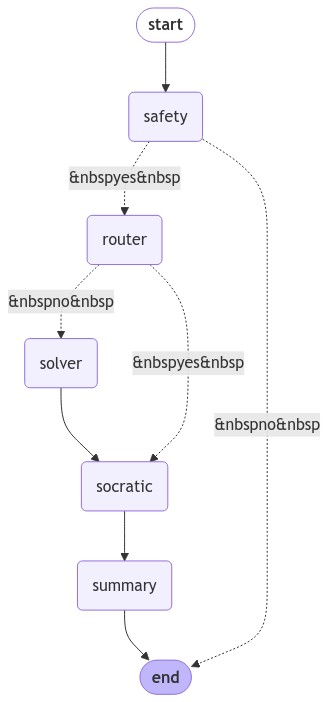

In [56]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [57]:
from langchain_core.messages import BaseMessage

query = "What is hashing?"
unsafe_query = "what is hacking?"

In [58]:
for event in graph.stream({"query": query, "context": "", "response": ""}):
    for value in event.values():
        # if value["safe"] == "no":
        #     print("Sorry, I can't answer that request.")
        # else:
        #     print("Content:", value["context"])
        #     print("Response:", value["response"])
        #     # print("Assistant:", value["response"].content)
        print(value)

Retrying langchain_google_vertexai.chat_models._completion_with_retry.<locals>._completion_with_retry_inner in 4.0 seconds as it raised ResourceExhausted: 429 Quota exceeded for aiplatform.googleapis.com/generate_content_requests_per_minute_per_project_per_base_model with base model: gemini-1.5-flash. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/generative-ai/quotas-genai..


{'safe': 'yes', 'query': 'What is hashing?', 'context': '', 'response': ''}
{'safe': 'yes', 'query': 'What is hashing?', 'context': '', 'solved': 'no', 'response': ''}
{'safe': 'yes', 'query': 'What is hashing?', 'context': "Hashing is a technique used to map keys to indices in a hash table. It allows for efficient search, insertion, and deletion of data. \n\nHere's how it works:\n\n1. **Hash Function:** A hash function takes a key as input and returns a hash value (an integer). This hash value represents the index in the hash table where the key-value pair will be stored.\n\n2. **Hash Table:** A hash table is a data structure that stores key-value pairs. It consists of an array of buckets, where each bucket can hold multiple key-value pairs.\n\n3. **Collision Handling:** When two different keys map to the same index, a collision occurs. Collision handling techniques, like chaining or open addressing, are used to resolve these collisions.\n\nHashing is used in various applications, inc

Retrying langchain_google_vertexai.chat_models._completion_with_retry.<locals>._completion_with_retry_inner in 4.0 seconds as it raised ResourceExhausted: 429 Quota exceeded for aiplatform.googleapis.com/generate_content_requests_per_minute_per_project_per_base_model with base model: gemini-1.5-flash. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/generative-ai/quotas-genai..
Retrying langchain_google_vertexai.chat_models._completion_with_retry.<locals>._completion_with_retry_inner in 4.0 seconds as it raised ResourceExhausted: 429 Quota exceeded for aiplatform.googleapis.com/generate_content_requests_per_minute_per_project_per_base_model with base model: gemini-1.5-flash. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/generative-ai/quotas-genai..
Retrying langchain_google_vertexai.chat_models._completion_with_retry.<locals>._completion_with_retry_inner in 4.0 seconds as it raised ResourceExhausted: 429 Quota exceeded fo

{'safe': 'yes', 'query': 'What is hashing?', 'context': "Hashing is a technique used to map keys to indices in a hash table. It allows for efficient search, insertion, and deletion of data. \n\nHere's how it works:\n\n1. **Hash Function:** A hash function takes a key as input and returns a hash value (an integer). This hash value represents the index in the hash table where the key-value pair will be stored.\n\n2. **Hash Table:** A hash table is a data structure that stores key-value pairs. It consists of an array of buckets, where each bucket can hold multiple key-value pairs.\n\n3. **Collision Handling:** When two different keys map to the same index, a collision occurs. Collision handling techniques, like chaining or open addressing, are used to resolve these collisions.\n\nHashing is used in various applications, including:\n\n* **Dictionaries:** In Python, dictionaries use hashing to store key-value pairs.\n* **Databases:** Hashing is used for indexing and searching data in databa

In [ ]:
import uuid
config = {"configurable": {"thread_id": str(uuid.uuid4())}}

events = graph.stream({"query": query})

for event in events:
    for value in event.values():
        value["response"].pretty_print()

KeyError: 'response'